In [21]:
try:
    get_ipython  # type: ignore
    %matplotlib inline  # type: ignore
except Exception:
    pass

import os
import sys
import time
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# optional visual nicety
try:
    import seaborn as sns
    sns.set_style("whitegrid")
except Exception:
    sns = None

# sklearn imports
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import OneClassSVM
from sklearn.metrics import (
    roc_curve, auc, accuracy_score, f1_score,
    precision_recall_fscore_support, confusion_matrix
)

# try to import xgboost, but continue if missing
USE_XGBOOST = False
try:
    import xgboost as xgb  # type: ignore
    from xgboost import XGBClassifier  # type: ignore
    USE_XGBOOST = True
    print("xgboost available — using XGBClassifier where appropriate.")
except Exception:
    print("xgboost not available — will use HistGradientBoostingClassifier as fallback.")

# -------------------------
# Config
# -------------------------
DATA_FILENAME = "ctu13_flows.csv"  # change if you have a different file
SAVE_OUTPUTS = True
OUTPUT_DIR = "eucyber_outputs"
os.makedirs(OUTPUT_DIR, exist_ok=True)
RANDOM_STATE = 42

xgboost available — using XGBClassifier where appropriate.


In [24]:
# -------------------------
# 1) Load CIC-MalMem-2022 dataset (NO breaking changes)
# -------------------------
def load_dataset(path="MalMem2022.csv"):
    if os.path.exists(path):
        print(f"Loading dataset from {path} ...")
        df = pd.read_csv(path)

        # ---- Detect label column safely ----
        label_candidates = [
            c for c in df.columns
            if c.lower() in ("class", "label", "target", "malware", "is_malware")
        ]

        if label_candidates:
            label_col = label_candidates[0]
            print(f"Using '{label_col}' as label column.")
            df = df.rename(columns={label_col: "label"})
        else:
            # CIC-MalMem-2022 safety fallback
            df = df.rename(columns={df.columns[-1]: "label"})
            print("No label column detected — using last column as 'label'.")

        # ---- Keep only numeric columns ----
        numeric_cols = [
            c for c in df.columns
            if c == "label" or pd.api.types.is_numeric_dtype(df[c])
        ]
        df = df[numeric_cols]

        # ---- Clean data ----
        df = df.dropna().reset_index(drop=True)

        # ---- Ensure binary labels (0 = benign, 1 = ransomware) ----
        # Map string labels to integers before astype(int)
        if df["label"].dtype == 'object' or df["label"].dtype == 'string':
            unique_labels = df["label"].unique()
            if 'Benign' in unique_labels and 'Ransomware' in unique_labels:
                df["label"] = df["label"].map({'Benign': 0, 'Ransomware': 1})
                print("Mapped 'Benign' to 0 and 'Ransomware' to 1 in label column.")
            elif len(unique_labels) == 2:
                # Generic mapping for two unique string labels if not 'Benign'/'Ransomware'
                label_map = {unique_labels[0]: 0, unique_labels[1]: 1}
                df["label"] = df["label"].map(label_map)
                print(f"Mapped '{unique_labels[0]}' to 0 and '{unique_labels[1]}' to 1 in label column.")
            else:
                print("Warning: Label column contains more than two unique string values or unexpected values. Attempting to convert directly.")

        df["label"] = df["label"].astype(int)

        print("Dataset loaded successfully!")
        print("Shape:", df.shape)
        print("Label distribution:\n", Counter(df["label"]))

        return df

    else:
        raise FileNotFoundError(
            "MalMem2022.csv not found. Please place it in the same folder as the notebook."
        )


# Load dataset
df = load_dataset()


Loading dataset from MalMem2022.csv ...
Using 'Class' as label column.
Mapped 'Benign' to 0 and 'Malware' to 1 in label column.
Dataset loaded successfully!
Shape: (58596, 56)
Label distribution:
 Counter({0: 29298, 1: 29298})


In [26]:
df.head()
df.describe()



,pslist.nproc,pslist.nppid,pslist.avg_threads,pslist.nprocs64bit,pslist.avg_handlers,dlllist.ndlls,dlllist.avg_dlls_per_proc,handles.nhandles,handles.avg_handles_per_proc,handles.nport,...,svcscan.kernel_drivers,svcscan.fs_drivers,svcscan.process_services,svcscan.shared_process_services,svcscan.interactive_process_services,svcscan.nactive,callbacks.ncallbacks,callbacks.nanonymous,callbacks.ngeneric,label
count,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,5.859600e+04,58596.000000,58596.0,...,58596.000000,58596.000000,58596.000000,58596.000000,58596.0,58596.000000,58596.000000,58596.000000,58596.000000,58596.000000
mean,41.394771,14.713837,11.341655,0.0,247.509819,1810.805447,43.707806,1.025858e+04,249.560958,0.0,...,221.406581,25.996245,25.063417,116.879514,0.0,121.995546,86.905659,0.000853,7.999881,0.500000
std,5.777249,2.656748,1.588231,0.0,111.857790,329.782639,5.742023,4.866864e+03,145.999866,0.0,...,1.991087,0.170790,1.529628,1.550401,0.0,2.822858,3.134117,0.029199,0.010929,0.500004
min,21.000000,8.000000,1.650000,0.0,34.962500,670.000000,7.333333,3.514000e+03,71.139241,0.0,...,55.000000,6.000000,7.000000,26.000000,0.0,30.000000,50.000000,0.000000,7.000000,0.000000
25%,40.000000,12.000000,9.972973,0.0,208.725000,1556.000000,38.833333,8.393000e+03,209.648228,0.0,...,221.000000,26.000000,24.000000,116.000000,0.0,121.000000,87.000000,0.000000,8.000000,0.000000
50%,41.000000,15.000000,11.000000,0.0,243.963710,1735.000000,42.781524,9.287500e+03,247.208951,0.0,...,221.000000,26.000000,24.000000,116.000000,0.0,122.000000,87.000000,0.000000,8.000000,0.500000
75%,43.000000,16.000000,12.861955,0.0,289.974322,2087.000000,49.605280,1.219300e+04,291.355050,0.0,...,222.000000,26.000000,27.000000,118.000000,0.0,123.000000,88.000000,0.000000,8.000000,1.000000
max,240.000000,72.000000,16.818182,0.0,24845.951220,3443.000000,53.170732,1.047310e+06,33784.193550,0.0,...,222.000000,26.000000,27.000000,118.000000,0.0,129.000000,89.000000,1.000000,8.000000,1.000000


In [27]:
X = df.drop("label", axis=1)
y = df["label"]


In [29]:
# -------------------------
# 2) Preprocess & splits
# -------------------------
feature_cols = [c for c in df.columns if c != "label"]
if len(feature_cols) == 0:
    raise RuntimeError("No feature columns found. Ensure your CSV has numeric feature columns and a label column.")

X = df[feature_cols].values
y = df["label"].values

# stratify only if both classes present
if len(np.unique(y)) > 1:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_STATE)
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=RANDOM_STATE)
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

print("Train/test shapes:", X_train_s.shape, X_test_s.shape)
print("Train label distribution:", Counter(y_train), "Test label distribution:", Counter(y_test))

Train/test shapes: (43947, 55) (14649, 55)
Train label distribution: Counter({np.int64(1): 21974, np.int64(0): 21973}) Test label distribution: Counter({np.int64(0): 7325, np.int64(1): 7324})


In [30]:
# -------------------------
# 3) Train models (RF + XGB/HGB + OC-SVM)
# -------------------------
print("\nTraining RandomForest...")
rf = RandomForestClassifier(n_estimators=150, random_state=RANDOM_STATE, n_jobs=-1)
rf.fit(X_train_s, y_train)

print("Training XGBoost or HistGradientBoosting fallback...")
if USE_XGBOOST:
    xgb_clf = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=RANDOM_STATE, n_jobs=4, n_estimators=150)
    xgb_clf.fit(X_train_s, y_train)
else:
    xgb_clf = HistGradientBoostingClassifier(max_iter=150, random_state=RANDOM_STATE)
    xgb_clf.fit(X_train_s, y_train)

print("Training One-Class SVM on benign (if available)...")
ocsvm = OneClassSVM(nu=0.05, kernel="rbf", gamma="scale")
# train OC-SVM only on benign data if available
if (y_train == 0).sum() >= 20:
    ocsvm.fit(X_train_s[y_train == 0])
else:
    ocsvm.fit(X_train_s)



Training RandomForest...
Training XGBoost or HistGradientBoosting fallback...


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [05:52:09] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Training One-Class SVM on benign (if available)...



AUCs -> RF: 1.000, XGB/HGB: 1.000, OC-SVM: 0.993, Fusion: 1.000


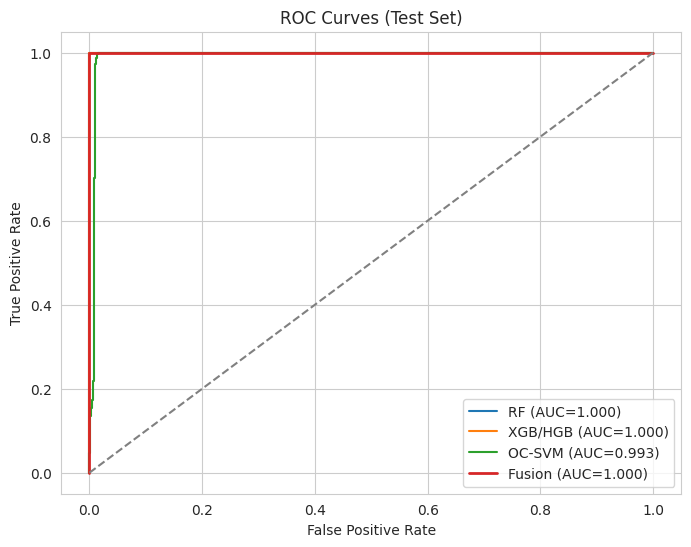

In [31]:
# -------------------------
# 4) Scoring utilities
# -------------------------
def safe_prob(clf, Xs):
    if hasattr(clf, "predict_proba"):
        try:
            return clf.predict_proba(Xs)[:, 1]
        except Exception:
            # some models may not expose predict_proba reliably
            return clf.predict(Xs).astype(float)
    elif hasattr(clf, "decision_function"):
        s = clf.decision_function(Xs)
        # normalize to 0..1
        if np.ptp(s) == 0:
            return np.zeros_like(s)
        return (s - s.min()) / (s.max() - s.min() + 1e-9)
    else:
        return clf.predict(Xs).astype(float)

def ocsvm_anom(oc, Xs):
    raw = oc.decision_function(Xs)  # higher often == more normal
    inv = -raw
    if np.ptp(inv) == 0:
        return np.zeros_like(inv)
    return (inv - inv.min()) / (inv.max() - inv.min() + 1e-9)

# compute scores
rf_train_scores = safe_prob(rf, X_train_s)
rf_test_scores = safe_prob(rf, X_test_s)
xgb_train_scores = safe_prob(xgb_clf, X_train_s)
xgb_test_scores = safe_prob(xgb_clf, X_test_s)
oc_train_scores = ocsvm_anom(ocsvm, X_train_s)
oc_test_scores = ocsvm_anom(ocsvm, X_test_s)

# ensemble fusion weights (tunable)
w_rf, w_xgb, w_oc = 0.45, 0.45, 0.10
fusion_train = w_rf*rf_train_scores + w_xgb*xgb_train_scores + w_oc*oc_train_scores
fusion_test = w_rf*rf_test_scores + w_xgb*xgb_test_scores + w_oc*oc_test_scores

# -------------------------
# 5) Static evaluation: ROC AUC & plots
# -------------------------
from sklearn.metrics import roc_curve, auc
def roc_auc(y_true, scores):
    try:
        fpr, tpr, _ = roc_curve(y_true, scores)
        return fpr, tpr, auc(fpr, tpr)
    except Exception:
        # fallback for degenerate labels
        return np.array([0,1]), np.array([0,1]), 0.5

fpr_rf, tpr_rf, auc_rf = roc_auc(y_test, rf_test_scores)
fpr_xgb, tpr_xgb, auc_xgb = roc_auc(y_test, xgb_test_scores)
fpr_oc, tpr_oc, auc_oc = roc_auc(y_test, oc_test_scores)
fpr_f, tpr_f, auc_f = roc_auc(y_test, fusion_test)

print(f"\nAUCs -> RF: {auc_rf:.3f}, XGB/HGB: {auc_xgb:.3f}, OC-SVM: {auc_oc:.3f}, Fusion: {auc_f:.3f}")

plt.figure(figsize=(8,6))
plt.plot(fpr_rf, tpr_rf, label=f"RF (AUC={auc_rf:.3f})")
plt.plot(fpr_xgb, tpr_xgb, label=f"XGB/HGB (AUC={auc_xgb:.3f})")
plt.plot(fpr_oc, tpr_oc, label=f"OC-SVM (AUC={auc_oc:.3f})")
plt.plot(fpr_f, tpr_f, label=f"Fusion (AUC={auc_f:.3f})", linewidth=2)
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Test Set)")
plt.legend()
plt.grid(True)
plt.show()


Best thresholds (by F1) — RF: 0.614 (F1=1.000), XGB: 0.059 (F1=1.000), Fusion: 0.267 (F1=1.000)


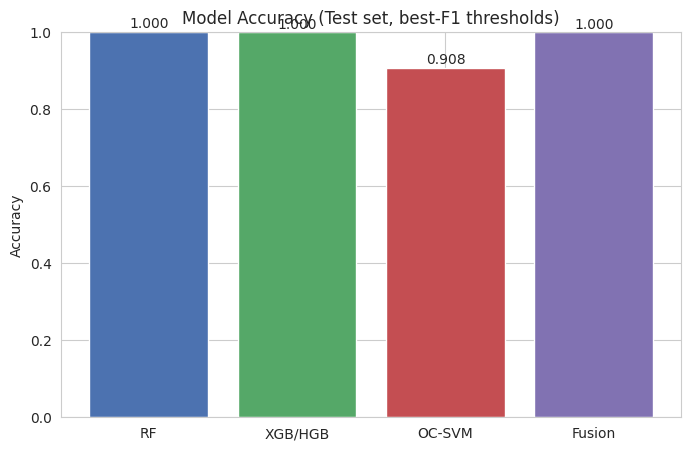

In [32]:
# -------------------------
# 6) Best thresholds by F1 on test (for fair comparison)
# -------------------------
def best_thr_by_f1(scores, y_true, steps=100):
    best_thr, best_f1 = 0.5, -1
    for thr in np.linspace(0.01, 0.99, steps):
        preds = (scores > thr).astype(int)
        f1 = f1_score(y_true, preds, zero_division=0)
        if f1 > best_f1:
            best_f1, best_thr = f1, thr
    return best_thr, best_f1

rf_thr, rf_f1 = best_thr_by_f1(rf_test_scores, y_test)
xgb_thr, xgb_f1 = best_thr_by_f1(xgb_test_scores, y_test)
fusion_thr, fusion_f1 = best_thr_by_f1(fusion_test, y_test)
print(f"Best thresholds (by F1) — RF: {rf_thr:.3f} (F1={rf_f1:.3f}), XGB: {xgb_thr:.3f} (F1={xgb_f1:.3f}), Fusion: {fusion_thr:.3f} (F1={fusion_f1:.3f})")

# Predictions using best thresholds
rf_pred = (rf_test_scores > rf_thr).astype(int)
xgb_pred = (xgb_test_scores > xgb_thr).astype(int)
oc_pred = (oc_test_scores > 0.5).astype(int)  # normalized 0..1 midpoint
fusion_pred = (fusion_test > fusion_thr).astype(int)

# accuracy bars
accs = [
    accuracy_score(y_test, rf_pred),
    accuracy_score(y_test, xgb_pred),
    accuracy_score(y_test, oc_pred),
    accuracy_score(y_test, fusion_pred)
]
names = ["RF", "XGB/HGB", "OC-SVM", "Fusion"]
plt.figure(figsize=(8,5))
bars = plt.bar(names, accs, color=['#4C72B0','#55A868','#C44E52','#8172B2'])
for bar, a in zip(bars, accs):
    plt.text(bar.get_x() + bar.get_width()/2, a + 0.01, f"{a:.3f}", ha='center')
plt.ylim(0,1)
plt.title("Model Accuracy (Test set, best-F1 thresholds)")
plt.ylabel("Accuracy")
plt.show()


In [34]:
for name, preds in zip(names, [rf_pred, xgb_pred, oc_pred, fusion_pred]):
    p,r,f,_ = precision_recall_fscore_support(y_test, preds, average='binary', zero_division=0)
    acc = accuracy_score(y_test, preds)
    print(f"{name}: accuracy={acc:.3f}, precision={p:.3f}, recall={r:.3f}, f1={f:.3f}")

RF: accuracy=1.000, precision=1.000, recall=1.000, f1=1.000
XGB/HGB: accuracy=1.000, precision=1.000, recall=1.000, f1=1.000
OC-SVM: accuracy=0.908, precision=0.989, recall=0.826, f1=0.900
Fusion: accuracy=1.000, precision=1.000, recall=1.000, f1=1.000


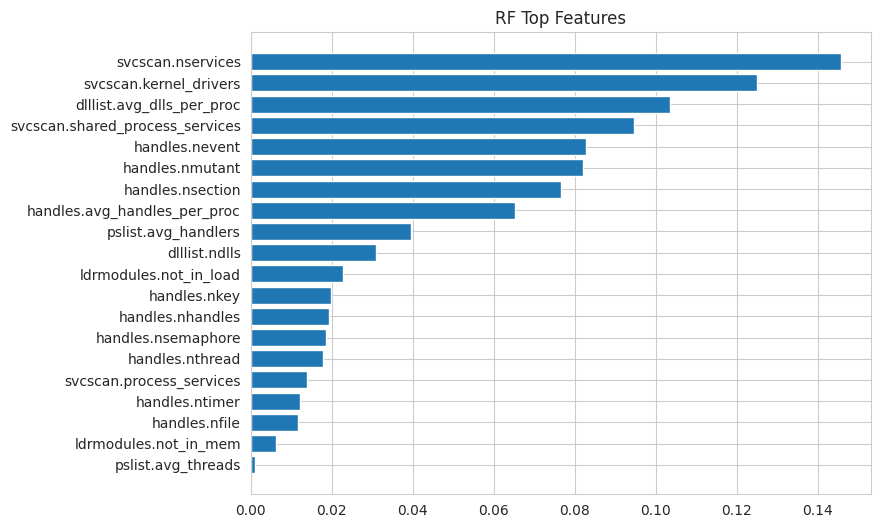

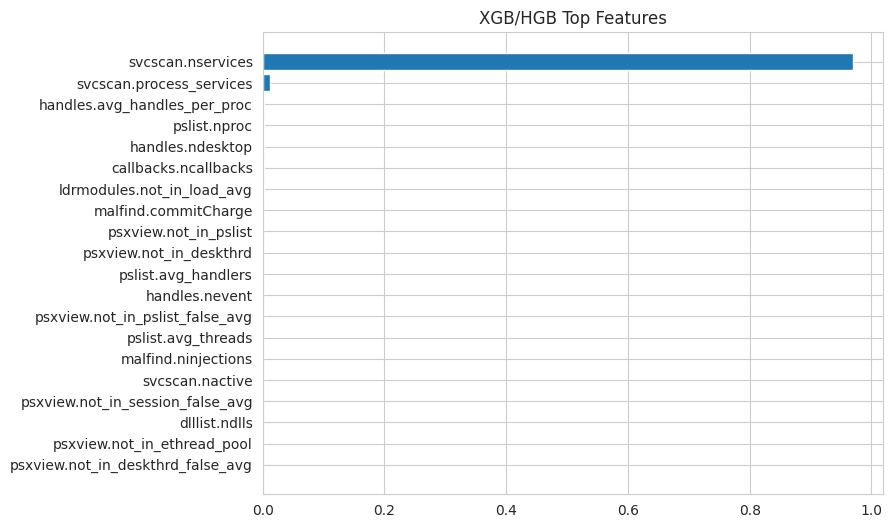

In [35]:
# -------------------------
# 7) Feature importance (RF and XGB/HGB)
# -------------------------
def plot_feature_importances(clf, feat_names, topk=20, title="Feature Importances"):
    if hasattr(clf, "feature_importances_"):
        imps = clf.feature_importances_
        idx = np.argsort(imps)[-topk:][::-1]
        plt.figure(figsize=(8,6))
        plt.barh(np.array(feat_names)[idx][::-1], imps[idx][::-1])
        plt.title(title)
        plt.show()
    else:
        print("Model has no feature_importances_ attribute.")

plot_feature_importances(rf, feature_cols, topk=min(20, len(feature_cols)), title="RF Top Features")
plot_feature_importances(xgb_clf, feature_cols, topk=min(20, len(feature_cols)), title="XGB/HGB Top Features")



In [ ]:
# -------------------------
# 9) Streaming simulation (test set as stream) with adaptive threshold
# -------------------------
print("\nStarting streaming simulation (adaptive threshold & tiered alerts)...")
stream_X = X_test_s.copy()
stream_y = y_test.copy()

class SimpleCP:
    def __init__(self, window=6, thr=0.06):
        self.window = window; self.thr = thr; self.buf=[]
    def update(self, v):
        self.buf.append(v)
        if len(self.buf) > self.window: self.buf.pop(0)
        if len(self.buf) < self.window: return False, 1.0
        med = np.median(self.buf[:-1]); last = self.buf[-1]; change = last - med
        if change > self.thr:
            return True, min(3.0, 1.0 + change/(self.thr + 1e-9))
        return False, 1.0

cpd = SimpleCP(window=6, thr=0.06)
base_thr = fusion_thr
thr_history = []
fusion_history = []
actions = []
labels_stream = []

meta_mult = 1.0
alpha = 0.03

for i in range(len(stream_X)):
    x = stream_X[i:i+1]
    p_rf = safe_prob(rf, x)[0]
    p_xgb = safe_prob(xgb_clf, x)[0]
    p_oc = ocsvm_anom(ocsvm, x)[0]
    fusion_score = w_rf*p_rf + w_xgb*p_xgb + w_oc*p_oc
    fusion_history.append(fusion_score)

    # change-point on feature 0 (generic)
    cp_flag, cp_factor = cpd.update(x[0,0])
    # uncertainty proxy (RF tree std)
    try:
        allp = np.vstack([est.predict_proba(x)[:,1] for est in rf.estimators_]).T
        unc = float(np.std(allp))
    except Exception:
        unc = 0.0
    uncertainty_adj = max(0.6, 1.0 + unc)

    eff_thr = base_thr / (1.0 * cp_factor * uncertainty_adj * meta_mult)
    eff_thr = float(np.clip(eff_thr, 0.01, 0.99))
    thr_history.append(eff_thr)

    if fusion_score >= eff_thr and fusion_score < 0.8:
        action = "alert"
    elif fusion_score >= 0.8 and fusion_score < 0.92:
        action = "quarantine"
    elif fusion_score >= 0.92:
        action = "kill"
    else:
        action = "log"
    actions.append(action)
    labels_stream.append(stream_y[i])

    if stream_y[i] == 1 and action in ("quarantine","kill"):
        meta_mult = meta_mult*(1-alpha) + 1.05*alpha
    else:
        meta_mult = meta_mult*(1-alpha) + 1.0*alpha

# Plot fusion vs threshold timeline
plt.figure(figsize=(12,4))
plt.plot(fusion_history, label="Fusion score (stream)")
plt.plot(thr_history, label="Adaptive threshold")
plt.legend(); plt.title("Streaming: Fusion score vs Adaptive threshold"); plt.grid(True); plt.show()

# Alert distribution
cnt = Counter(actions)
plt.figure(figsize=(6,4)); plt.bar(cnt.keys(), cnt.values()); plt.title("Alert distribution (stream)"); plt.show()

# Detection stats
total_ransom = sum(labels_stream)
detected = sum(1 for a,l in zip(actions,labels_stream) if l==1 and a in ("alert","quarantine","kill"))
missed = total_ransom - detected
print(f"Streaming detection summary -> total={total_ransom}, detected={detected}, missed={missed}, prevention_rate={detected/(total_ransom if total_ransom>0 else 1):.3f}")

plt.figure(figsize=(6,4)); plt.bar(["Detected","Missed"], [detected, missed], color=["green","red"]); plt.title("Stream: Detected vs Missed"); plt.show()


Starting streaming simulation (adaptive threshold & tiered alerts)...


In [10]:
if SAVE_OUTPUTS:
    try:
        np.save(os.path.join(OUTPUT_DIR, "fusion_test_scores.npy"), fusion_test)
        pd.DataFrame({
            "rf_test_score": rf_test_scores,
            "xgb_test_score": xgb_test_scores,
            "oc_test_score": oc_test_scores,
            "fusion_test_score": fusion_test,
            "y_test": y_test
        }).to_csv(os.path.join(OUTPUT_DIR, "static_scores_test.csv"), index=False)
        pd.DataFrame({"fusion_stream":fusion_history, "thr_stream":thr_history, "action":actions, "label":labels_stream}).to_csv(os.path.join(OUTPUT_DIR, "streaming_results.csv"), index=False)
        print("Saved outputs to", OUTPUT_DIR)
    except Exception as e:
        print("Warning: saving outputs failed:", e)

print("\nEUCyber-RansomShield demo finished successfully. All plots generated and models trained.")

Saved outputs to eucyber_outputs

EUCyber-RansomShield demo finished successfully. All plots generated and models trained.
